# TinyGPT

**Autor: Abraham R.**

Este cuaderno es un ejemplo de un modelo GPT realmente pequeño llamado **TinyGPT**.
Repasarás la arquitectura GPT (transformer *decoder*) e implementarás las siguientes tareas:

## Arquitectura de TinyGPT

Diseñado para el [curso NLP‑II](https://github.com/FIUBA-Posgra...), consiste en un **GPT con *Mixture of Experts***, equivalente a modelos como:
- DeepSeek
- Mistral

## Tareas

Usando TinyGPT debes implementar las siguientes modificaciones:
...

## Arquitectura
- Convertir TinyGPT en un *Mixture of Experts* (MoE) con al menos 2 expertos.

## ¿Qué esperar?

- Comprender en profundidad la implementación de un modelo GPT.
- Implementar una capa MoE para crear un modelo GPT de vanguardia.
- Explorar algoritmos de decodificación para generación de texto.

### NOTA

La tokenización está fuera de alcance; usaremos un tokenizador por caracteres, sencillo pero ineficiente.


In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import torch
from torch import nn
import torch.nn.functional as F
from dataclasses import dataclass, field
from typing import Optional, List, Type
import httpx

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from trainer_local import Trainer
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR

In [2]:
import torch, sys
print("Torch:", torch.__version__)
print("CUDA build en torch:", torch.version.cuda)   # None = wheel solo CPU
print("CUDA disponible:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

Torch: 2.5.1+cu121
CUDA build en torch: 12.1
CUDA disponible: True
GPU: NVIDIA GeForce RTX 3060 Ti


## Descargando el conjunto de datos

In [3]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = httpx.get(url)
text = response.text

text = text[:100_000]  # Using 100k characters for speedup
print(text)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



# Codificación basada en caracteres

In [4]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}
def encode(s): return [stoi[c] for c in s]
def decode(l): return ''.join([itos[i] for i in l])
data = torch.tensor(encode(text), dtype=torch.long)

# División entrenamiento/prueba
split = int(0.9 * len(data))
train_data = data[:split]
val_data = data[split:]

# Cargadores de datos

In [5]:
class CharDataset(Dataset):
    def __init__(self, data: torch.Tensor, block_size: int):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.block_size]
        y = self.data[idx + 1 : idx + self.block_size + 1]
        return x, y

# Configuración de GPT

In [6]:
@dataclass
class MoEArgs():
    """
    MoE input arguments class.
    """
    num_experts : int = field(default=4)
    num_experts_per_token : int = field(default=2)

@dataclass
class GPTConfig:
    """
    Base class for GPT models.
    """
    block_size: int = 32
    batch_size: int = 8
    n_embd: int = 64
    n_head: int = 4
    n_layer: int = 2
    dropout: float = 0.1
    vocab_size: int = vocab_size
    bias: bool = True
    ff_class: Optional[Type[nn.Module]] = None
    moe : Optional[MoEArgs] = None

config = GPTConfig()
print(config.__dict__)

{'block_size': 32, 'batch_size': 8, 'n_embd': 64, 'n_head': 4, 'n_layer': 2, 'dropout': 0.1, 'vocab_size': 61, 'bias': True, 'ff_class': None, 'moe': None}


In [7]:
train_dataset = CharDataset(train_data, config.block_size)
val_dataset = CharDataset(val_data, config.block_size)

train_loader = DataLoader(train_dataset,
                        batch_size=config.batch_size,
                        shuffle=True,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 0, # if using mps set num_workers as 0.
                        )
val_loader = DataLoader(val_dataset,
                        batch_size=config.batch_size,
                        shuffle=False,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 0,
                        )

In [8]:
class AttentionHead(nn.Module):
    """
    Scaled Dot-Product Attention Head for Multi-Head Attention.
    """
    def __init__(self, args: GPTConfig) -> None:
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.head_dim = args.n_embd // args.n_head

# Proyección QKV combinada
        self.key_query_value = nn.Linear(args.n_embd, 3 * self.head_dim, bias=args.bias)

        self.dropout = nn.Dropout(args.dropout)
        self.block_size = args.block_size
        self.register_buffer('tril', torch.tril(torch.ones(args.block_size, args.block_size)))

    def forward(self, x: torch.Tensor, kv_cache: Optional[torch.Tensor] = None, return_weights=False):
        B, T, C = x.shape
        key_query_value = self.key_query_value(x)  # (B, T, 3 * head_dim)
        k, q, v = torch.chunk(key_query_value, 3, dim=-1)  # (B, T, head_dim) each

        if kv_cache is not None:
            key_cache, value_cache = kv_cache.unbind(dim=0)  # (B, T', head_dim)
            k = torch.cat((key_cache, k), dim=1)
            v = torch.cat((value_cache, v), dim=1)

# Atención de producto punto escalado
        wei = q @ k.transpose(-2, -1) * (self.head_dim ** -0.5)  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        out = wei @ v  # (B, T, head_dim)

        if return_weights:
            return out, wei

        if kv_cache is not None:
            return out, torch.stack((k, v))

        return out, None

In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(self, args: GPTConfig):
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.n_heads = args.n_head
        self.head_dim = args.n_embd // args.n_head

        self.heads = nn.ModuleList([
            AttentionHead(args) for _ in range(self.n_heads)
        ])

        self.proj = nn.Linear(args.n_embd, args.n_embd, bias=args.bias)
        self.dropout = nn.Dropout(args.dropout)

    def forward(self, x, kv_cache=None, return_weights=False):
        all_outputs = []
        all_weights = []
        new_kv_cache = [] if kv_cache is not None else None

        for i, head in enumerate(self.heads):
            head_cache = kv_cache[i] if kv_cache is not None else None
            out, weights_or_kv = head(x, kv_cache=head_cache, return_weights=return_weights)
            all_outputs.append(out)
            if return_weights:
                all_weights.append(weights_or_kv)
            if kv_cache is not None:
                new_kv_cache.append(weights_or_kv)  # weights_or_kv is new kv_cache here

        concat = torch.cat(all_outputs, dim=-1)  # concat along embedding dim
        out = self.dropout(self.proj(concat))

        if return_weights:
            return out, torch.stack(all_weights)
        if kv_cache is not None:
            return out, new_kv_cache
        return out

In [10]:
class FeedForward(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadAttention(config)

        ff_class = config.ff_class if config.ff_class is not None else FeedForward
        self.ff = ff_class(config)

    def forward(self, x, kv_cache=None, return_weights=False):
        attn_out = self.attn(self.ln1(x), kv_cache=kv_cache, return_weights=return_weights)
        if return_weights:
            attn_out, weights = attn_out
        else:
            weights = None

        if isinstance(attn_out, tuple):
            attn_out, updated_kv = attn_out
        else:
            updated_kv = None

        x = x + attn_out
        x = x + self.ff(self.ln2(x))
        return (x, updated_kv, weights) if return_weights else (x, updated_kv)

## Arquitectura de TinyGPT

In [11]:
class TinyGPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.token_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Embedding(config.block_size, config.n_embd)
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.config = config

    def forward(self, idx, kv_cache=None, return_weights=False):
        B, T = idx.shape
        tok_emb = self.token_emb(idx)
        pos = torch.arange(T, device=idx.device)
        pos_emb = self.pos_emb(pos)[None, :, :]
        x = tok_emb + pos_emb

        new_kv_cache = [] if kv_cache is not None else None
        all_weights = [] if return_weights else None

        for i, block in enumerate(self.blocks):
            layer_kv = kv_cache[i] if kv_cache is not None else None
            if return_weights:
                x, updated_kv, weights = block(x, kv_cache=layer_kv, return_weights=True)
                all_weights.append(weights)  # weights shape: (n_heads, B, T, T)
            else:
                x, updated_kv = block(x, kv_cache=layer_kv)
            if kv_cache is not None:
                new_kv_cache.append(updated_kv)

        x = self.ln_f(x)
        logits = self.head(x)

        if return_weights:
            if kv_cache is not None:
                return logits, new_kv_cache, all_weights
            else:
                return logits, all_weights
        else:
            if kv_cache is not None:
                return logits, new_kv_cache
            return logits

## Función de generación (inferencia)

In [12]:
@torch.no_grad()
def generate(prompt: str, max_new_tokens: int = 100, use_cache: bool = True):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        probs = F.softmax(logits[:, -1, :], dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

# Configuración

In [13]:
# Selección de dispositivo: CUDA > MPS > CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TinyGPT(config).to(device)

# # Compilar sólo si estás en CUDA; si falla, caer al modelo sin compilar
# try:
#     model = torch.compile(m) if device.type == "cuda" else m
# except Exception as e:
#     print("torch.compile desactivado:", e)
#     model = m

print("Device:", device, "|",
      ("GPU: " + torch.cuda.get_device_name(0)) if device.type == "cuda" else "GPU: -")

Device: cuda | GPU: NVIDIA GeForce RTX 3060 Ti


In [14]:
optimizer = AdamW(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 2

# Entrenamiento

In [15]:
xb, yb = next(iter(train_loader))
print("Train sample:", xb.shape, yb.shape)  # (batch_size, block_size)

Train sample: torch.Size([8, 32]) torch.Size([8, 32])


In [16]:
# Instancia del Trainer
trainer = Trainer(
    model=model,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device.type,
    save_dir="./checkpoints",
    save_every_n=500,
)

# Entrenamiento
for epoch in range(epochs):  
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Época {epoch+1} - pérdida de entrenamiento: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Época {epoch+1} - pérdida de validación: {val_loss:.4f}")

print("Entrenamiento completo.")

loss 2.11099: 100%|██████████| 11246/11246 [02:30<00:00, 74.90it/s]


Época 1 - pérdida de entrenamiento: 2.1099


val_loss 2.05237: 100%|██████████| 1246/1246 [00:05<00:00, 215.87it/s]


Época 1 - pérdida de validación: 2.0445


loss 2.14747: 100%|██████████| 11246/11246 [02:28<00:00, 75.87it/s]


Época 2 - pérdida de entrenamiento: 2.0877


val_loss 2.05236: 100%|██████████| 1246/1246 [00:05<00:00, 213.88it/s]

Época 2 - pérdida de validación: 2.0445
Entrenamiento completo.


### Prueba rápida

In [17]:
generate("To be", max_new_tokens=100,use_cache=True) 

"To bety you o':\nYou briustourer ad,\nWe an'd ben the\nbupst howerte wolich, I ashert: thand wand reve sheis"

# Tarea I

Usando TinyGPT debes implementar las siguientes modificaciones:


## Inferencia: modifica la función `generate` para:
- Decodificación *greedy* (seleccionar el token con mayor probabilidad).
- Muestreo por temperatura.
- Muestreo *top‑k* o *top‑p*.

### Referencias
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)


In [18]:
@torch.no_grad()
def generateV2(prompt: str,
             max_new_tokens: int = 100,
             temperature: float = 1.0,
             top_k: int = 10,
             top_p: float = 0.9,
             mode: str = "greedy",  # "greedy", "sampling"
             use_cache: bool = True) -> Optional[str]:

    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        # Contexto: último token o ventana entera
        idx_cond = idx[:, -1:] if use_cache and kv_cache is not None else idx[:, -config.block_size:]
        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        # Último paso de logits
        logits = logits[:, -1, :] / temperature
        probs = F.softmax(logits, dim=-1)

        if mode == "greedy":
            next_token = torch.argmax(probs, dim=-1, keepdim=True)

        elif mode == "sampling":
            # === Top‑k ===
            if top_k is not None:
                values, indices = torch.topk(probs, top_k)
                probs_k = torch.zeros_like(probs).scatter_(1, indices, values)
                probs = probs_k / probs_k.sum(dim=-1, keepdim=True)

            # === Top‑p (nucleus sampling) ===
            elif top_p is not None:
                sorted_probs, sorted_indices = torch.sort(probs, descending=True)
                cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
                mask = cumulative_probs > top_p
                # Keep at least one token
                mask[..., 1:] = mask[..., :-1].clone()
                mask[..., 0] = False
                sorted_probs[mask] = 0
                probs = torch.zeros_like(probs).scatter(1, sorted_indices, sorted_probs)
                probs = probs / probs.sum(dim=-1, keepdim=True)

            next_token = torch.multinomial(probs, num_samples=1)

        else:
            raise ValueError("Modo no válido: usar 'greedy' o 'sampling'")

        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())


## Comparar `generate` vs `generateV2`

Añade tus comentarios y conclusiones

In [19]:
result_1 = generate("To be", max_new_tokens=100, use_cache=True)
result_2 = generateV2("To be", max_new_tokens=100, mode="sampling", use_cache=True)

In [20]:
print("result 1: ", result_1)
print("result 2: ", result_2)

result 1:  To bet uwey:
Yous to fall we, gos?

OLUWe ber atwir you ch, ithand:
Ple owy fyirel droy?

MENENIUS:
Whice
result 2:  To bee bot sto sed.

BRUS:
That he bethay yours mid the mat thavey therese ondy
Thins thy herit bart out



## Tarea II
- Convierte TinyGPT en un *Mixture of Experts* (MoE) con al menos 2 expertos.

In [21]:
class Expert(nn.Module):
    """
    An expert MLP instance from within a MoE.
    """

    def __init__(self,config:GPTConfig) -> None:
        """
        Initiates expert MLP given dimensions/hidden dimensions.
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout)
        ) ## Example network

    def forward(self, x) -> torch.Tensor:
        return self.net(x)


class Gate(nn.Module):
    """
    MoE gating network MLP.
    """

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.proj = nn.Linear(config.n_embd, config.moe.num_experts)

    def forward(self, x):
        return self.proj(x)

In [22]:
# class MoELayer(nn.Module):
#     """
#     Mixture of experts FeedForward Layer
#     """

#     def __init__(self, experts : List[nn.Module], gate : nn.Module, moe_args : MoEArgs):
#         super().__init__()
#         self.experts = nn.ModuleList(experts)
#         self.gate = gate
#         self.args = moe_args

#     def forward(self, x : torch.Tensor) -> torch.Tensor:


#         return None

In [47]:
class MoELayer(nn.Module):
    """
    Mixture of Experts FeedForward Layer (FFN) con top-k routing.
    """
    def __init__(self, experts: List[nn.Module], gate: nn.Module, moe_args: MoEArgs):
        super().__init__()
        self.experts = nn.ModuleList(experts)
        self.gate = gate
        self.args = moe_args

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, T, C)  -> salida: (B, T, C)
        E: num_experts, k: num_experts_per_token
        """
        B, T, C = x.shape
        E = len(self.experts)
        k = self.args.num_experts_per_token

        # 1) Gating: logits y probabilidades por experto
        gate_logits = self.gate(x)                # (B, T, E)
        gate_probs = torch.softmax(gate_logits, dim=-1)  # (B, T, E)

        # 2) Top-k: índices y pesos de los k mejores expertos por token
        topk_probs, topk_idx = torch.topk(gate_probs, k, dim=-1)  # (B, T, k), (B, T, k)

        # (opcional pero recomendable) renormalizar los k pesos para que sumen 1
        topk_probs = topk_probs / (topk_probs.sum(dim=-1, keepdim=True) + 1e-9)

        # 3) Ejecutar TODOS los expertos (simple; para eficiencia habría que despachar por experto)
        #    Cada experto devuelve (B, T, C); apilamos en dim=0 => (E, B, T, C)
        expert_outputs = []
        for e in range(E):
            expert_outputs.append(self.experts[e](x))  # cada uno: (B, T, C)
        expert_outputs = torch.stack(expert_outputs, dim=2)  # (B, T, E, C)

        # 4) Construir máscara one-hot para los top-k por token
        #    one_hot_topk: (B, T, E) con 1 en expertos seleccionados, 0 en el resto
        # one_hot_topk = torch.zeros(B, T, E, device=x.device, dtype=expert_outputs.dtype)
        one_hot_topk = torch.zeros(B, T, E, device=x.device, dtype=topk_probs.dtype)

        one_hot_topk.scatter_(dim=2, index=topk_idx, src=torch.ones_like(topk_probs))
        

        # 5) Pesar con los top-k probs: expandimos probs a (B, T, E, 1) y multiplicamos
        weights = (one_hot_topk * 0)  # solo para declarar; reusamos dtype/dispositivo
        weights = torch.zeros_like(one_hot_topk)
        weights.scatter_(dim=2, index=topk_idx, src=topk_probs)  # (B, T, E)
        weights = weights.unsqueeze(-1)                           # (B, T, E, 1)

        # 6) Combinación ponderada de salidas de expertos
        #    salida: sum_e [ weights[..., e, :] * expert_outputs[..., e, :] ]  -> (B, T, C)
        y = (expert_outputs * weights).sum(dim=2)  # (B, T, C)

        return y


In [48]:
class MoEFFN(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.moe = MoELayer(  
            experts=[Expert(config) for _ in range(config.moe.num_experts)],
            gate=Gate(config),
            moe_args=config.moe
        )

    def forward(self, x):
        return self.moe(x)

## Añadiendo MoE a la configuración

In [49]:
config.ff_class = MoEFFN
config.moe = MoEArgs(num_experts=4, num_experts_per_token=1)

# Entrenamiento de TinyGPT‑MoE

In [50]:
print(device)
print(type(device))

cuda
<class 'str'>


In [51]:

device = "cuda" if torch.cuda.is_available() else "cpu"
m_moe = TinyGPT(config).to(device)
model_moe = m_moe


In [52]:
optimizer = AdamW(model_moe.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 2

In [53]:
# Instancia del Trainer
trainer = Trainer(
    model=model_moe,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Entrenamiento
for epoch in range(epochs): 
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Época {epoch+1} - pérdida de entrenamiento: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Época {epoch+1} - pérdida de validación: {val_loss:.4f}")

print("Entrenamiento completo.")

loss 2.17698: 100%|██████████| 11246/11246 [03:05<00:00, 60.51it/s]


Época 1 - pérdida de entrenamiento: 2.1914


val_loss 2.14924: 100%|██████████| 1246/1246 [00:07<00:00, 168.89it/s]


Época 1 - pérdida de validación: 2.0903


loss 2.20115: 100%|██████████| 11246/11246 [03:06<00:00, 60.29it/s]


Época 2 - pérdida de entrenamiento: 2.1790


val_loss 2.14924: 100%|██████████| 1246/1246 [00:07<00:00, 165.89it/s]

Época 2 - pérdida de validación: 2.0903
Entrenamiento completo.


In [54]:
@torch.no_grad()
def generateV2_with_model(model: nn.Module,
                          prompt: str,
                          max_new_tokens: int = 100,
                          temperature: float = 1.0,
                          top_k: int = 10,
                          top_p: float = 0.9,
                          mode: str = "greedy",
                          use_cache: bool = True) -> Optional[str]:

    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        idx_cond = idx[:, -1:] if use_cache and kv_cache is not None else idx[:, -config.block_size:]
        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        logits = logits[:, -1, :] / temperature
        probs = F.softmax(logits, dim=-1)

        if mode == "greedy":
            next_token = torch.argmax(probs, dim=-1, keepdim=True)

        elif mode == "sampling":
            if top_k is not None:
                values, indices = torch.topk(probs, top_k)
                probs_k = torch.zeros_like(probs).scatter_(1, indices, values)
                probs = probs_k / probs_k.sum(dim=-1, keepdim=True)

            elif top_p is not None:
                sorted_probs, sorted_indices = torch.sort(probs, descending=True)
                cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
                mask = cumulative_probs > top_p
                mask[..., 1:] = mask[..., :-1].clone()
                mask[..., 0] = False
                sorted_probs[mask] = 0
                probs = torch.zeros_like(probs).scatter(1, sorted_indices, sorted_probs)
                probs = probs / probs.sum(dim=-1, keepdim=True)

            next_token = torch.multinomial(probs, num_samples=1)

        else:
            raise ValueError("Modo no válido: usar 'greedy' o 'sampling'")

        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())


In [55]:
result_3 = generateV2_with_model(model_moe, "To be", max_new_tokens=100, mode="sampling", use_cache=True)
print(result_3)

To best to'l is, swand
Cith wellerecir is,
Ougir, as mutrind, the thadteret to wastowng it, the sthe ho m


## Visualización de la atención

Como sabemos, un GPT tiene la tarea de completar texto; veamos los mapas de atención generados por un modelo preentrenado

In [56]:
@torch.no_grad()
def visualize_attention(model, prompt, max_len=10):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)

# Ejecutar forward con return_weights=True
    logits, all_weights = model(idx, return_weights=True)

# all_weights es una lista de longitud n_layers
# cada elemento: shape (n_heads, batch_size, seq_len, seq_len)
# Solo visualizaremos el primer elemento del batch

    n_layers = len(all_weights)
    n_heads = all_weights[0].shape[0]
    seq_len = all_weights[0].shape[-1]

    for layer_i in range(n_layers):
        fig, axes = plt.subplots(1, n_heads, figsize=(5 * n_heads, 5))
        if n_heads == 1:
            axes = [axes]
        for head_i in range(n_heads):
            attn = all_weights[layer_i][head_i, 0].cpu()  # shape (seq_len, seq_len)
            im = axes[head_i].imshow(attn, cmap='viridis')
            axes[head_i].set_title(f'Layer {layer_i + 1} Head {head_i + 1}')
            axes[head_i].set_xlabel('Key Position')
            axes[head_i].set_ylabel('Query Position')
            axes[head_i].set_xticks(range(seq_len))
            axes[head_i].set_yticks(range(seq_len))
            fig.colorbar(im, ax=axes[head_i])
        plt.tight_layout()
        plt.show()

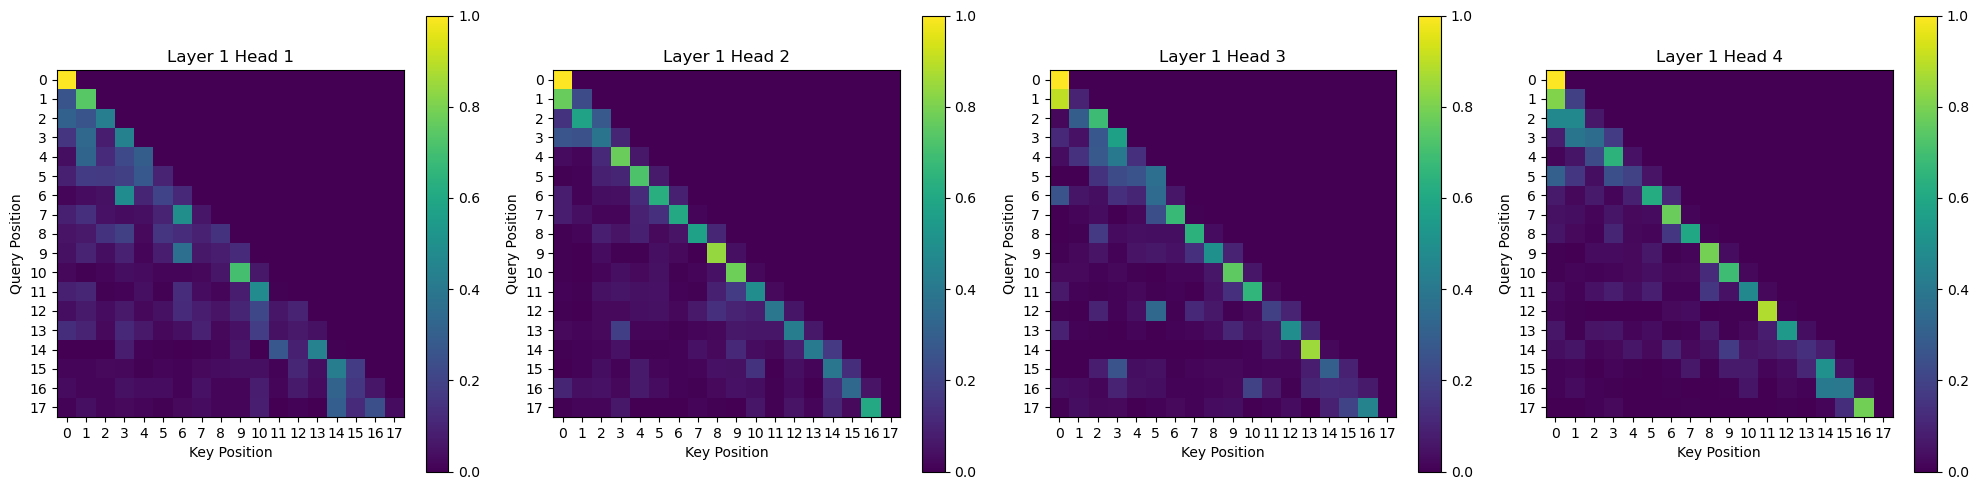

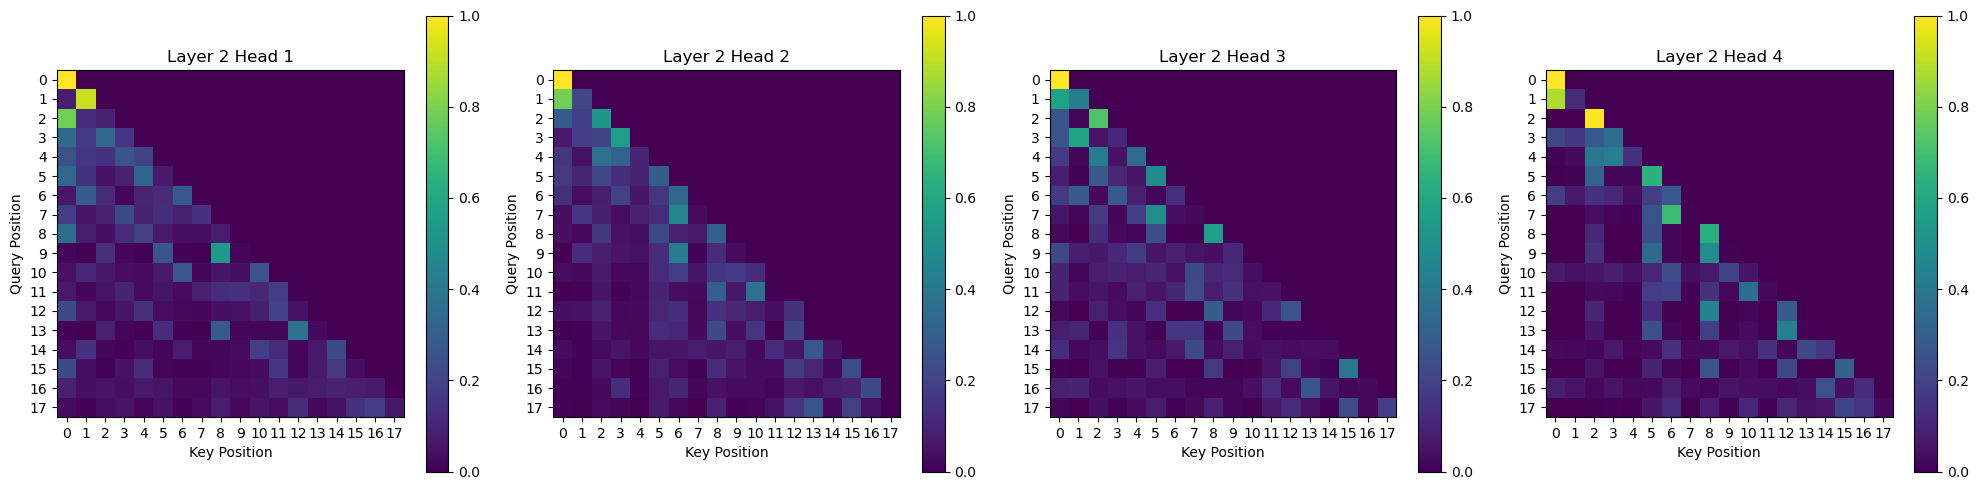

In [ ]:
prompt = "To be or not to be"
visualize_attention(model_moe, prompt)

# Conclusiones

- 
- 